# **Computer Vision**
## **Assignment II**

### Yash Maniya (B20CS033)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage import io, color
from sklearn.cluster import KMeans
from scipy.ndimage import generic_filter


### **Q1. Segmentation using Ratio-Cut Algorithm**

#### Clustering Algorithms

In [2]:
class ImageManipulation:
    def __init__(self, image_path):
        if not isinstance(image_path, str):
            self.image = image_path
            return
        self.image_path = image_path
        self.image = Image.open(image_path)
        self.image_resized = None

    def resize_image(self, size=(64, 64)):
        self.image_resized = self.image.resize(size)

    def get_original_image(self):
        return np.array(self.image)

    def get_resized_image(self):
        return np.array(self.image_resized)
    
    def convert_to_single_channel(self, image):
        height, width, _ = image.shape
        single_channel_image = np.zeros((height, width), dtype=np.uint32)

        for i in range(height):
            for j in range(width):
                single_channel_image[i, j] = image[i, j, 0] * 1000000 + image[i, j, 1] * 1000 + image[i, j, 2]

        return single_channel_image

    def convert_to_rgb(self, single_channel_image):
        height, width = single_channel_image.shape
        rgb_image = np.zeros((height, width, 3), dtype=np.uint8)

        for i in range(height):
            for j in range(width):
                r = single_channel_image[i, j] // 1000000
                g = (single_channel_image[i, j] % 1000000) // 1000
                b = single_channel_image[i, j] % 1000

                # Set the RGB values in the output image
                rgb_image[i, j] = [r, g, b]

        return rgb_image.astype(np.uint32)

    def max_frequency_filter(self, window_size):
        if self.image.shape[0] <= 128:
            return self.image
        image = self.convert_to_single_channel(self.image)

        def element_with_max_frequency(array):            
            unique_values, counts = np.unique(array, return_counts=True)
            max_frequency_index = np.argmax(counts)
            max_frequency_element = unique_values[max_frequency_index]
            return max_frequency_element

        # Apply the argmax filter using generic_filter
        filtered_image = generic_filter(image, element_with_max_frequency, size=window_size)

        return self.convert_to_rgb(filtered_image)


class KMeansClustering:
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters

    def fit(self, image, feature_space):
        height, width, _ = image.shape
        pixel_values = np.reshape(image, (height * width, -1))

        if feature_space == "RGB":
            pixel_values_with_positions = pixel_values
        elif feature_space == "RGBxy":
            x_positions, y_positions = np.meshgrid(np.arange(height), np.arange(width))
            scaler = 1
            x_positions *= scaler
            x_positions *= scaler
            pixel_values_with_positions = np.concatenate((pixel_values, x_positions.reshape(-1, 1), y_positions.reshape(-1, 1)), axis=1)
        else:
            raise ValueError("Invalid feature space. Use 'RGB' or 'RGBxy'.")

        kmeans = KMeans(n_clusters=self.num_clusters, random_state=42).fit(pixel_values_with_positions)
        labels = kmeans.labels_
        raw_img = kmeans.cluster_centers_[labels]
        raw_img = np.array([x[:3] for x in raw_img])
        segmented_image = raw_img.reshape((height, width, 3))  # Reshape back to original image dimensions
        res = ImageManipulation(segmented_image.astype(np.uint8))
        window = height//50
        return res.max_frequency_filter(window)


class RatioCutClustering:
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters

    def _calculate_ratio_cut(self, adjacency_matrix, labels):
        cut_ratio = 0
        for i in range(self.num_clusters):
            indices_i = np.where(labels == i)[0]
            indices_not_i = np.where(labels != i)[0]
            
            # Ensure that indices are within bounds
            indices_i = indices_i[indices_i < adjacency_matrix.shape[0]]
            indices_not_i = indices_not_i[indices_not_i < adjacency_matrix.shape[0]]
            
            # Calculate the cut and ratio, handling the case where the denominator might be zero
            if len(indices_i) > 0:
                cut = np.sum(adjacency_matrix[np.ix_(indices_i, indices_not_i)])
                ratio = cut / len(indices_i)
                cut_ratio += ratio
        
        return cut_ratio / self.num_clusters

    def _create_adjacency_matrix(self, image):
        # Convert the image to grayscale
        gray_image = color.rgb2gray(image)
        
        # Compute gradients in x and y directions
        gradient_x = np.gradient(gray_image, axis=0)
        gradient_y = np.gradient(gray_image, axis=1)
        
        # Compute edge weights as the magnitude of gradients
        edge_weights = np.sqrt(gradient_x**2 + gradient_y**2)
        
        # Convert edge weights to similarity values
        adjacency_matrix = np.exp(-edge_weights)
        return adjacency_matrix

    def fit(self, image):
        # Convert the image to numpy array if it's not already
        if not isinstance(image, np.ndarray):
            image = io.imread(image)
        
        # Get the shape of the image
        height, width, _ = image.shape
        
        # Reshape the image into a 2D array of pixels
        pixel_values = np.reshape(image, (height * width, -1))
        
        # Perform KMeans clustering to get initial clustering
        kmeans = KMeans(n_clusters=self.num_clusters)
        labels = kmeans.fit_predict(pixel_values)
        
        # Create adjacency matrix
        adjacency_matrix = self._create_adjacency_matrix(image)
        
        # Initialize best cut ratio and best labels
        best_cut_ratio = float('inf')
        best_labels = None
        
        # Perform optimization
        for _ in range(10):  # Number of iterations for optimization
            # Calculate cut ratio for current labels
            cut_ratio = self._calculate_ratio_cut(adjacency_matrix, labels)
            
            # Update best cut ratio and best labels if needed
            if cut_ratio < best_cut_ratio:
                best_cut_ratio = cut_ratio
                best_labels = labels.copy()
            
            # Randomly reassign labels for optimization
            random_labels = np.random.randint(0, self.num_clusters, size=len(labels))
            random_cut_ratio = self._calculate_ratio_cut(adjacency_matrix, random_labels)
            
            # Update labels if random labels have lower cut ratio
            if random_cut_ratio < cut_ratio:
                labels = random_labels
        
        # Check if best_labels is None
        if best_labels is None:
            # If best_labels is still None, use labels from KMeans clustering
            best_labels = labels.copy()
        
        res = np.reshape(best_labels, (height, width))
        
        # Generate segmented image by assigning original colors
        segmented_image = np.zeros_like(image)
        for i in range(self.num_clusters):
            segmented_image[res == i] = np.mean(image[res == i], axis=0)
        
        res = ImageManipulation(segmented_image)
        window = height//50
        return res.max_frequency_filter(window)
        

class ImagePlotting:
    def plot_images(self, original_image, resized_image, segmented_image_kmeans, segmented_image_ratio_cut,
                    num_clusters, feature_space):
        fig, axes = plt.subplots(1, 3, figsize=(24, 16))

        axes[0].imshow(resized_image)
        axes[0].set_title('Resized Original Image')
        axes[0].axis('off')

        fs1 = 'RGB'
        if feature_space:
            fs1 = feature_space
        axes[1].imshow(segmented_image_kmeans)
        axes[1].set_title(f'K-Means Clustering\nNumber of Clusters: {num_clusters} ({fs1} space)')
        axes[1].axis('off')

        if feature_space:
            axes[2].imshow(segmented_image_ratio_cut)
            axes[2].set_title(f'Ratio-Cut Clustering\nNumber of Clusters: {num_clusters}')
            axes[2].axis('off')
        else:
            axes[2].imshow(segmented_image_ratio_cut)
            axes[2].set_title(f'K-Means Clustering\nNumber of Clusters: {num_clusters} (RGBxy space)')
            axes[2].axis('off')
        plt.show()


class SegmentationComparison:
    def __init__(self, image_paths, num_clusters_list):
        self.image_paths = image_paths
        self.num_clusters_list = num_clusters_list

    def compare_clustering(self, feature_space, resize_size=(256, 256)):
        for idx, image_path in enumerate(self.image_paths):
            image_manipulation = ImageManipulation(image_path)
            image_manipulation.resize_image(size=resize_size)

            original_image = image_manipulation.get_original_image()
            resized_image = image_manipulation.get_resized_image()

            image_plotting = ImagePlotting()

            for num_clusters in self.num_clusters_list:
                segmented_image_kmeans = KMeansClustering(num_clusters).fit(resized_image, feature_space)

                ratio_cut_clustering = RatioCutClustering(num_clusters)
                segmented_image_ratio_cut = ratio_cut_clustering.fit(resized_image)

                image_plotting.plot_images(original_image, resized_image, segmented_image_kmeans,
                                           segmented_image_ratio_cut, num_clusters, feature_space)

    def compare_feature_space(self, resize_size=(256, 256)):
        for idx, image_path in enumerate(self.image_paths):
            image_manipulation = ImageManipulation(image_path)
            image_manipulation.resize_image(size=resize_size)

            original_image = image_manipulation.get_original_image()
            resized_image = image_manipulation.get_resized_image()

            image_plotting = ImagePlotting()

            for num_clusters in self.num_clusters_list:
                segmented_image_kmeans_rgb = KMeansClustering(num_clusters).fit(resized_image, 'RGB')
                segmented_image_kmeans_rgbxy = KMeansClustering(num_clusters).fit(resized_image, 'RGBxy')

                image_plotting.plot_images(original_image, resized_image, segmented_image_kmeans_rgb,
                                           segmented_image_kmeans_rgbxy, num_clusters, None)



#### Testing given Images

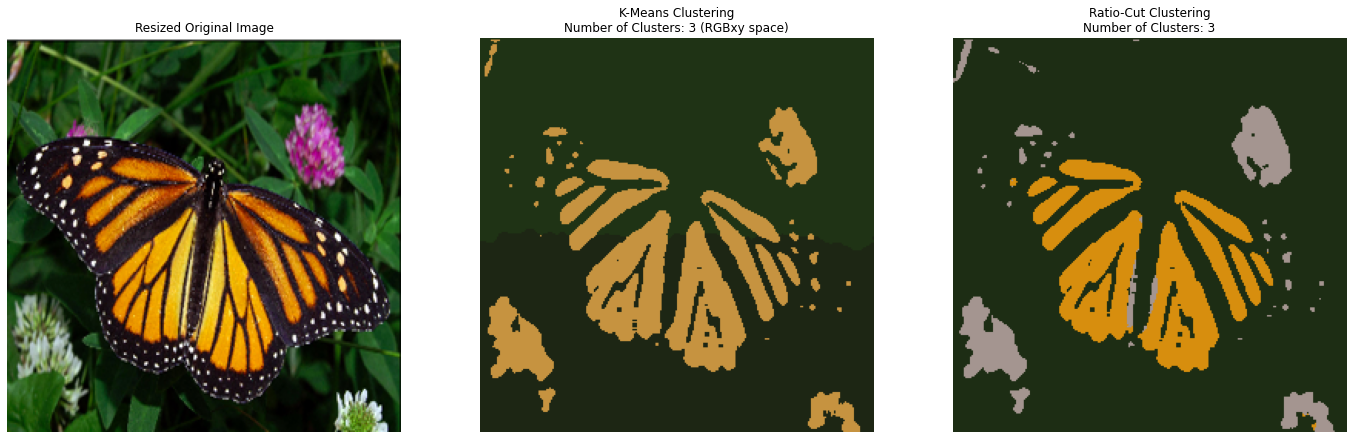

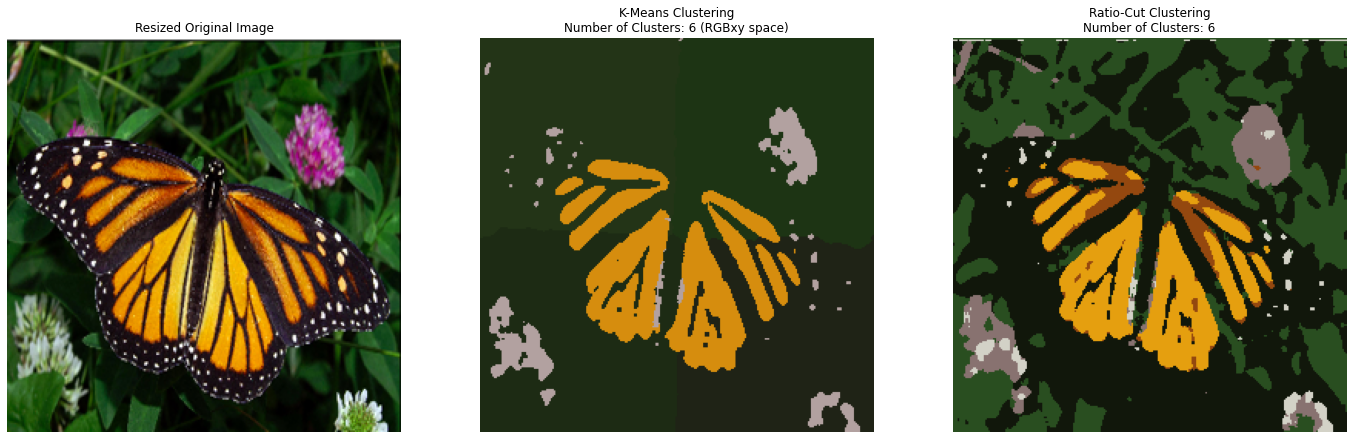

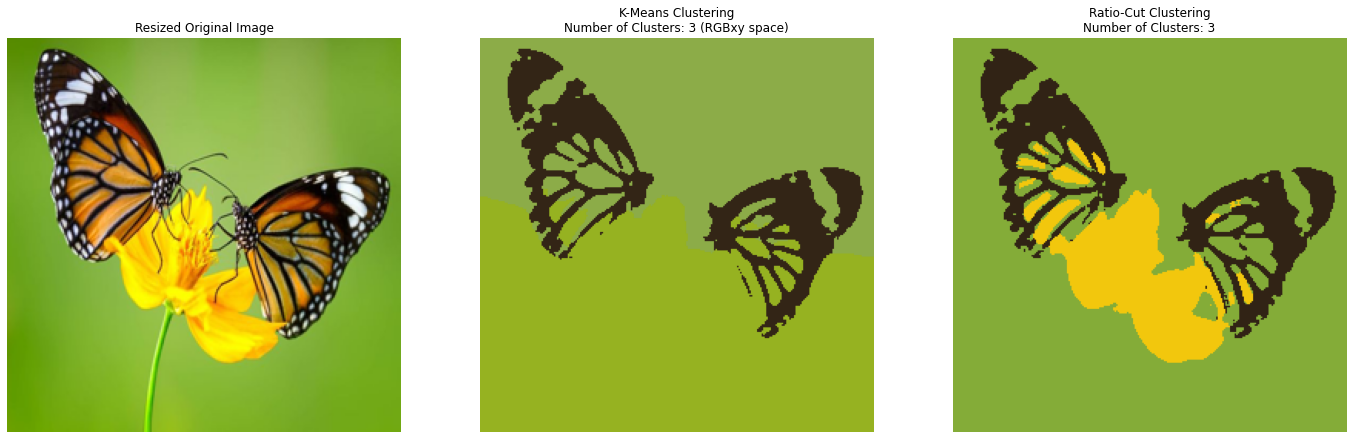

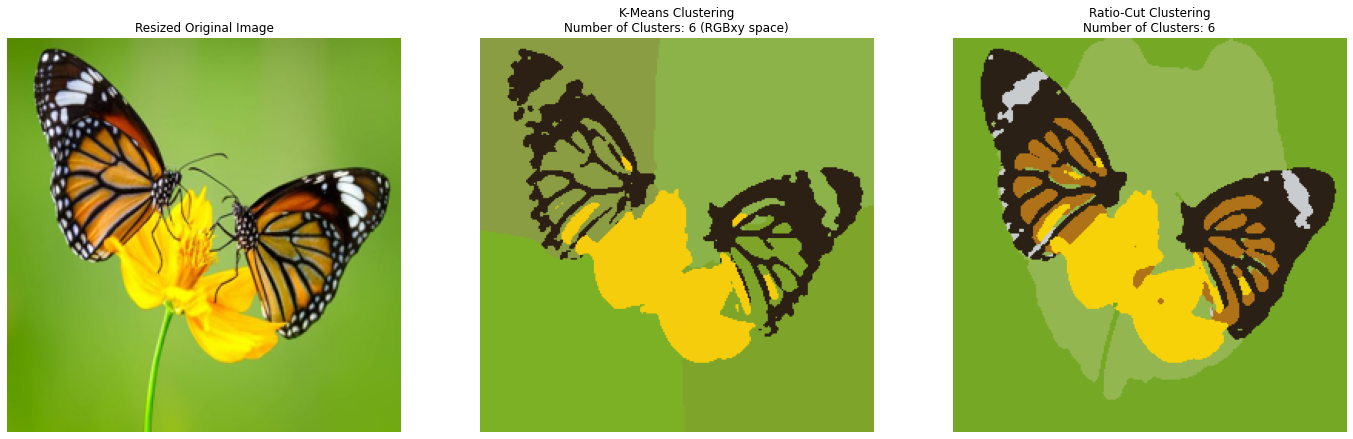

In [7]:
image_paths = ['./image1.jpg', './image2.jpg']
num_clusters_list = [3, 6]
feature_space = "RGBxy"  # Change this to switch between RGB and RGBxy
resize_size = (256, 256)  # Change this to resize the image

segmentation_comparison = SegmentationComparison(image_paths, num_clusters_list)
segmentation_comparison.compare_clustering(feature_space, resize_size)


#### Testing Extra Images (Vegetables)

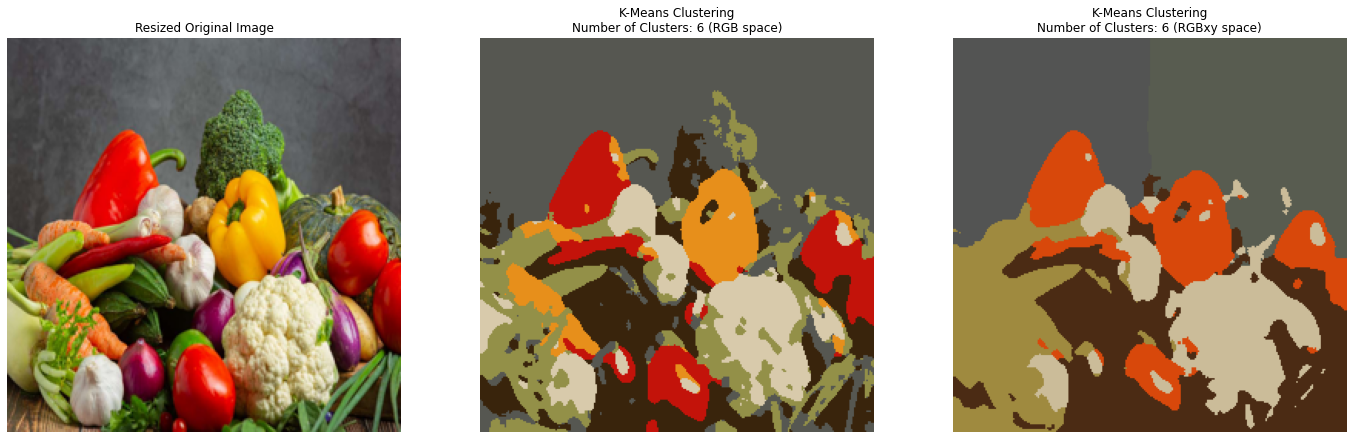

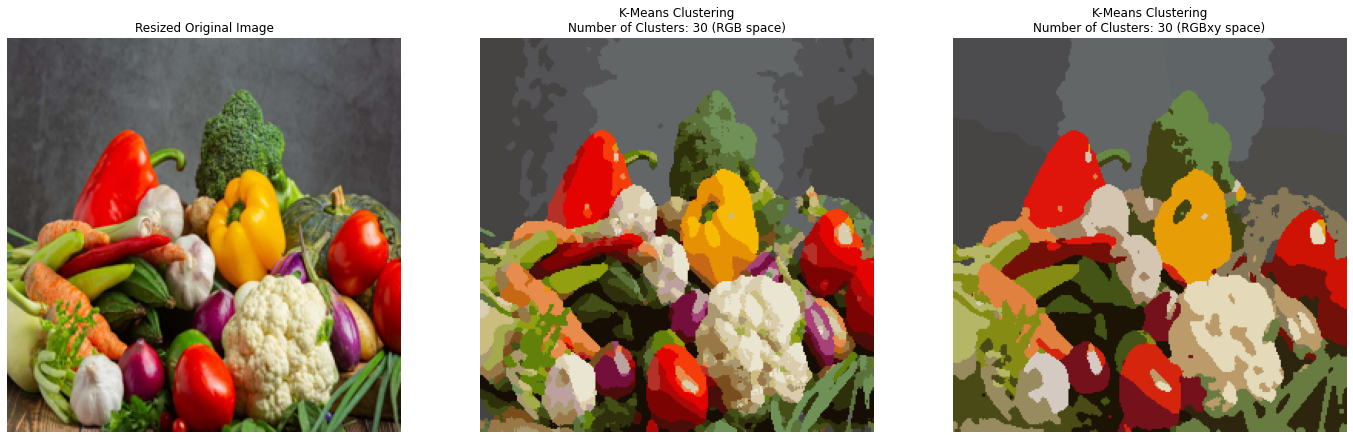

In [4]:
image_paths = ['./vegetables.jpg']
num_clusters_list = [6, 30]
feature_space = "RGBxy"  # Change this to switch between RGB and RGBxy
resize_size = (256, 256)  # Change this to resize the image

segmentation_comparison = SegmentationComparison(image_paths, num_clusters_list)
segmentation_comparison.compare_feature_space(resize_size)


#### Testing Extra Images (Flowers)

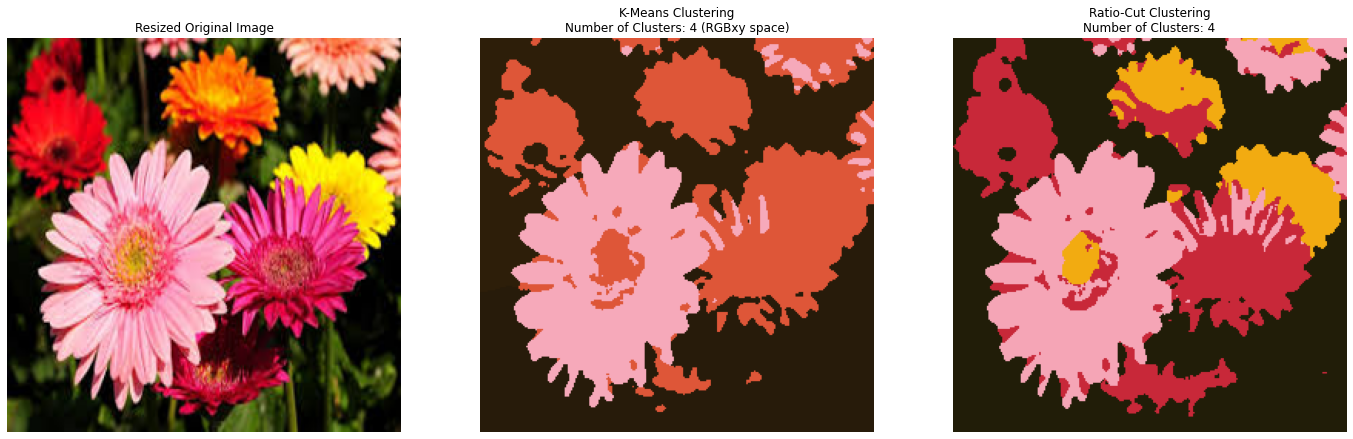

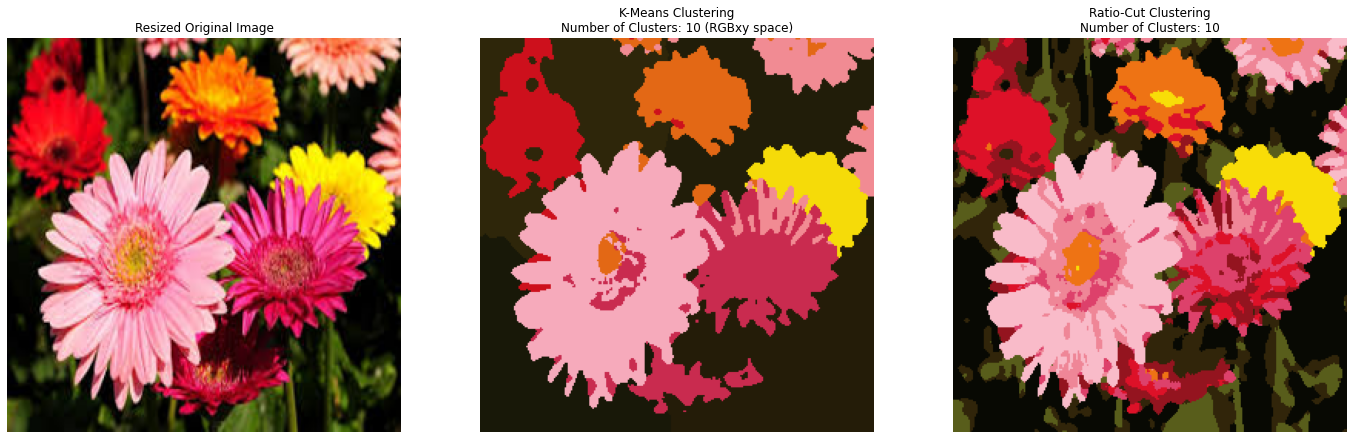

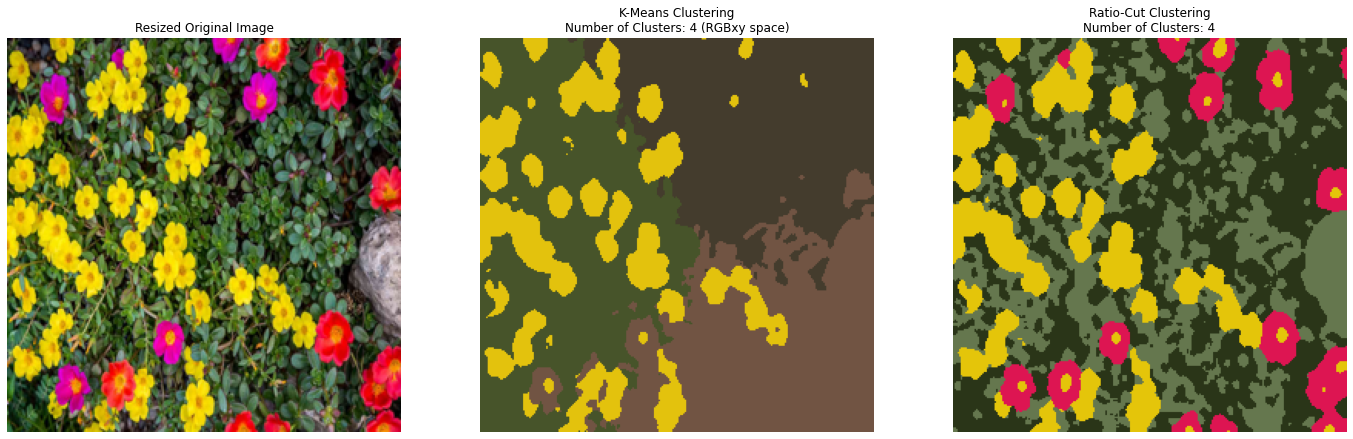

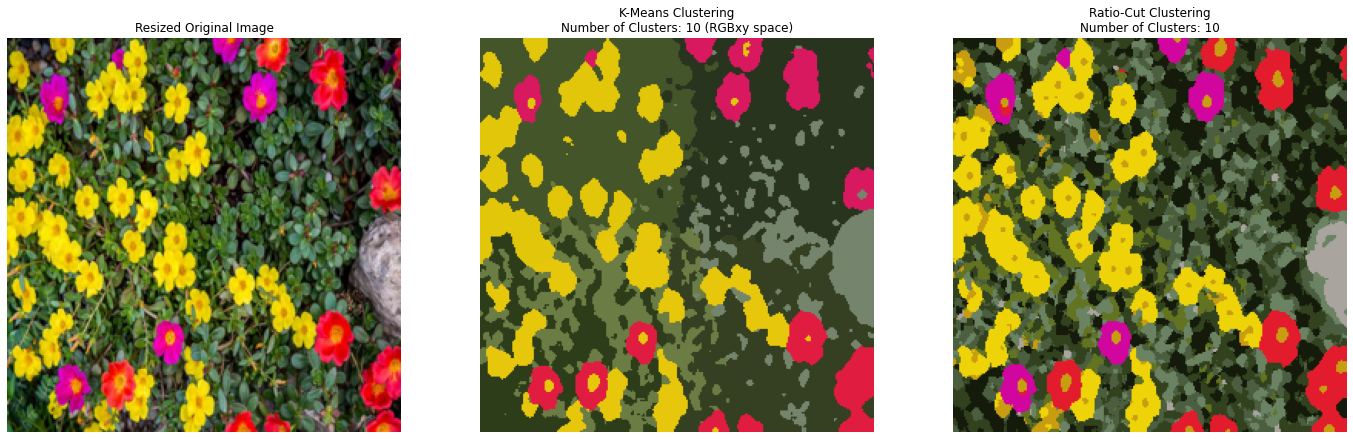

In [10]:
image_paths = ['./flowers1.jpeg', './flowers2.jpeg']
num_clusters_list = [4, 10]
feature_space = "RGBxy"  # Change this to switch between RGB and RGBxy
resize_size = (256, 256)  # Change this to resize the image

segmentation_comparison = SegmentationComparison(image_paths, num_clusters_list)
segmentation_comparison.compare_clustering(feature_space, resize_size)
